# Cluster Exploration

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import Birch, KMeans
import sklearn.metrics as metrics
from sklearn.neighbors import RadiusNeighborsRegressor, KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

#ignore minor warnings
import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare
import model as m

In [2]:
df_in = acquire.get_data(query_url = False)
print(df_in.shape)
df_in = prepare.prepare_dataframe(df_in)
train, validate, test = prepare.split_data(df_in)
train.shape, validate.shape, test.shape

Found file in working directory!
(70932, 83)


((40311, 60), (6719, 60), (6719, 60))

In [3]:
#list of clustering algorithms to use:


In [4]:
def k_means_clustering(df):
    outputs = list()
    prepared_df = m.prepare_model_df(df)
    pred_df = df[['id', 'name', 'usd']]
    for n_clusters in range(2, 20):
        clusterer = KMeans(n_clusters=n_clusters)
        preds = clusterer.fit_predict(prepared_df.loc[:, ~prepared_df.columns.isin(['id', 'name', 'usd'])])
        centers = clusterer.cluster_centers_
        
        score = metrics.silhouette_score(prepared_df.loc[:, ~prepared_df.columns.isin(['id', 'name', 'usd'])], preds)
        output = {
            'k_clusters': n_clusters,
            'score': score
        }
        outputs.append(output)
        pred_df[f"{n_clusters}_cluster_labels"] = preds
    return outputs, pred_df
    
# output_metrics, cluster_df = k_means_clustering(train)

In [5]:
# output_metrics

In [17]:
def add_cluster_column(df, cluster_algo, algo_name):
    prepared_df = m.prepare_model_df(df)
    algo = cluster_algo
    algo = algo.fit(prepared_df.loc[:, ~prepared_df.columns.isin(['id', 'name', 'usd'])])
    preds = algo.predict(prepared_df.loc[:, ~prepared_df.columns.isin(['id', 'name', 'usd'])])
    score = metrics.silhouette_score(prepared_df.loc[:, ~prepared_df.columns.isin(['id', 'name', 'usd'])], preds)
    output = {
        'model_name': algo_name,
        'score': score
    }
    return output, preds

def make_multi_clusters(df, model, model_name):
    outputs = list()
    df_preds = df[['id', 'name', 'usd']]
    for num_clusters in range(2, 21):
        output, preds = add_cluster_column(df, model(n_clusters = num_clusters), f"{model_name}_{num_clusters}")
        outputs.append(output)
        df_preds[f"{model_name}_{num_clusters}"] = preds
    return outputs, df_preds

outputs_kmeans, cluster_df_kmeans = make_multi_clusters(train, KMeans, 'kmeans')
outputs_birch, cluster_df_birch = make_multi_clusters(train, Birch, 'birch')

In [26]:
outputs_kmeans

[{'model_name': 'kmeans_2', 'score': 0.21651321642619548},
 {'model_name': 'kmeans_3', 'score': 0.14147874554267512},
 {'model_name': 'kmeans_4', 'score': 0.15197298687147243},
 {'model_name': 'kmeans_5', 'score': 0.13489145380920933},
 {'model_name': 'kmeans_6', 'score': 0.13406982799718906},
 {'model_name': 'kmeans_7', 'score': 0.15490019492374915},
 {'model_name': 'kmeans_8', 'score': 0.1436414170201089},
 {'model_name': 'kmeans_9', 'score': 0.14579238816952667},
 {'model_name': 'kmeans_10', 'score': 0.1495117206128354},
 {'model_name': 'kmeans_11', 'score': 0.15065436199823265},
 {'model_name': 'kmeans_12', 'score': 0.14949134998661745},
 {'model_name': 'kmeans_13', 'score': 0.15197063283616033},
 {'model_name': 'kmeans_14', 'score': 0.15328577155231965},
 {'model_name': 'kmeans_15', 'score': 0.14617433131934016},
 {'model_name': 'kmeans_16', 'score': 0.150484034033655},
 {'model_name': 'kmeans_17', 'score': 0.15157259332788706},
 {'model_name': 'kmeans_18', 'score': 0.141941005451

In [69]:
cluster_df = cluster_df_kmeans.merge(cluster_df_birch, on = ['id', 'name', 'usd'])
cluster_df.groupby(['birch_18']).usd.mean()

birch_18
0      5.418006
1      1.909389
2      2.236445
3      2.113700
4      3.733517
5     61.327649
6      6.379172
7      5.217569
8      0.195450
9      0.617719
10     0.420038
11     2.182456
12     3.484408
13     3.282222
14     8.246627
15     0.355383
16     2.518238
17     2.276224
Name: usd, dtype: float64

In [66]:
y = cluster_df[['id', 'name', 'usd']].copy()
rn = DecisionTreeRegressor()
rn = rn.fit(cluster_df.loc[:, 'birch_2':], cluster_df['usd'])
y['predicted'] = rn.predict(cluster_df.loc[:, 'birch_2':])
mae_train = metrics.mean_absolute_error(cluster_df['usd'], y['predicted'])

<AxesSubplot:xlabel='usd', ylabel='residual'>

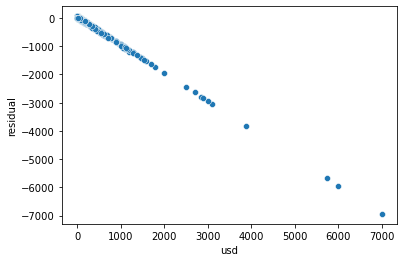

In [67]:
y['residual'] = y['predicted'] - y['usd']
sns.scatterplot(data = y, x = 'usd', y = 'residual')

In [68]:
mae_train

9.594874159774474